In [68]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2
from PyEyeSim import EyeData,extract_heatmap_arrays, extract_angle_arrays, RSA_from_angles, RSA_from_heatmaps, RSA_from_mem, extract_euc_dist_arrays, RSA_from_euc_dists, entropy_fix
import glob
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from scipy.spatial.distance import cdist
import seaborn as sns
from icecream import ic
import math
import numpy as np
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


dataframe preparation, unfortunately the fixation data wasnt really uniform

In [2]:
NUMBER_OF_SUBJECTS = 50
# subjects with different FOV
subjects_1920 = [1, 2, 3, 14, 15, 17, 18, 19, 20, 21, 22, 36, 37]
# FOV shift common
coordinate_shift_1280 = [262, 390]
# FOV shift rare
coordinate_shift_1920 = [290, 710]
# image pixels (quadratic)
IMAGE_DIMS = 500

NORM_DIMS = [1280, 920]

fixation_file_pattern ='*_FIX_R*'

filename_prototype = "/Users/juliusduin/Desktop/Master-Psychologie/MA/data/prep_fixs/"

fixation_files = glob.glob(filename_prototype+fixation_file_pattern)

all_subjects_df = pd.concat((pd.read_csv(file) for file in fixation_files))
all_subjects_df['subID_num'] = all_subjects_df['subID'].str.extract('(\d+)').astype(int)
all_subjects_df['viewing_position'] = all_subjects_df['subID_num'].apply(lambda x: 1 if x in subjects_1920 else 0)
all_subjects_df['x'] = all_subjects_df.apply(
    lambda row: row['mean_x'] - coordinate_shift_1920[1] if row['viewing_position'] == 1 else row['mean_x'] -
                                                                                              coordinate_shift_1280[1],
    axis=1)
all_subjects_df['y'] = all_subjects_df.apply(
    lambda row: row['mean_y'] - coordinate_shift_1920[0] if row['viewing_position'] == 1 else row['mean_y'] -
                                                                                              coordinate_shift_1280[0],
    axis=1)
all_subjects_df = all_subjects_df.drop(columns=['mean_x', 'mean_y'])
all_subjects_df['memory_bin'] = all_subjects_df['memory'].map({1: 1, 2: 1, 3: 2, 4: 2})

# extract scenes only
all_subjects_df = all_subjects_df[all_subjects_df.cat == 2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

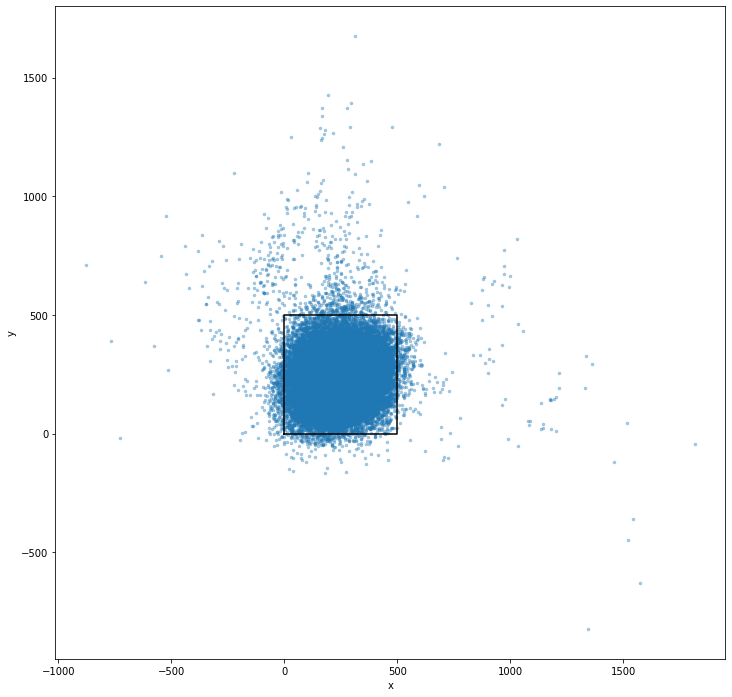

In [3]:
plt.figure(figsize=(12, 12))
frame = pd.DataFrame({
    'x': [0, 500, 500, 0, 0],
    'y': [0, 0, 500, 500, 0]
})
plt.plot(frame['x'], frame['y'], color='k')
sns.scatterplot(all_subjects_df.x, all_subjects_df.y, edgecolor=None, alpha=0.4, s=10)

In [4]:
MemData = EyeData('MemData', 'between', all_subjects_df, x_size=500,y_size=500)
MemData.DataInfo(FixDuration='duration',Stimulus='pic',subjectID='subID', mean_x='x', mean_y='y')
MemData.RunDescriptiveFix(Visual=0)

dataset size:  (37264, 13)
study design:  between
presentation size:  x= 500 pixels y= 500  pixels
presentation size:  x= 500 pixels y= 500  pixels
Stimulus  not found !!, provide column as Stimulus =YourColumn , default:  Stimulus
subjectID  not found !!, provide column as subjectID =YourColumn , default:  subjectID
mean_x  not found !!, provide column as mean_x =YourColumn , default:  mean_x
mean_y  not found !!, provide column as mean_y =YourColumn , default:  mean_y
info found for 46 subjects, and 192 stimuli
run descriptive analysis
Data for  46 observers and  192  stimuli.


/Users/juliusduin/Desktop/uni_work/PyEyeSim/PyEyeSim/__init__.py:94: UserWarning: Stim path not provided
  warnings.warn('Stim path not provided')
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Mean fixation number:  8.48  +/-  1.28
fixation duration not asked for
Num of trials with zero fixations: 0
Num valid trials  4392
Mean X location:  239.8  +/-  27.6  pixels
Mean Y location:  249.0  +/-  41.1  pixels
Mean saccade  amplitude:  127.6  +/-  18.6  pixels
Mean scanpath  length:  943.2  +/-  180.9  pixels
Data for  46 observers and  192  stimuli.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Mean fixation number:  8.48  +/-  1.28
fixation duration not asked for
Num of trials with zero fixations: 0
Num valid trials  4392
Mean X location:  239.8  +/-  27.6  pixels
Mean Y location:  249.0  +/-  41.1  pixels
Mean saccade  amplitude:  127.6  +/-  18.6  pixels
Mean scanpath  length:  943.2  +/-  180.9  pixels


(array(['set1_s_1.png', 'set1_s_10.png', 'set1_s_11.png', 'set1_s_12.png',
        'set1_s_13.png', 'set1_s_14.png', 'set1_s_15.png', 'set1_s_16.png',
        'set1_s_17.png', 'set1_s_18.png', 'set1_s_19.png', 'set1_s_2.png',
        'set1_s_20.png', 'set1_s_21.png', 'set1_s_22.png', 'set1_s_23.png',
        'set1_s_24.png', 'set1_s_25.png', 'set1_s_26.png', 'set1_s_27.png',
        'set1_s_28.png', 'set1_s_29.png', 'set1_s_3.png', 'set1_s_30.png',
        'set1_s_31.png', 'set1_s_32.png', 'set1_s_33.png', 'set1_s_34.png',
        'set1_s_35.png', 'set1_s_36.png', 'set1_s_37.png', 'set1_s_38.png',
        'set1_s_39.png', 'set1_s_4.png', 'set1_s_40.png', 'set1_s_41.png',
        'set1_s_42.png', 'set1_s_43.png', 'set1_s_44.png', 'set1_s_45.png',
        'set1_s_46.png', 'set1_s_47.png', 'set1_s_48.png', 'set1_s_49.png',
        'set1_s_5.png', 'set1_s_50.png', 'set1_s_51.png', 'set1_s_52.png',
        'set1_s_53.png', 'set1_s_54.png', 'set1_s_55.png', 'set1_s_56.png',
        'set1_s_5

extract data (heatmaps or angles) for every single subject and every stimulus

heatmaps with different resizing

In [5]:
try:
    with open('example_pkl/angles_ex.pkl', 'rb') as f:
        anglesFromMemData = pickle.load(f)
    with open('example_pkl/heatmaps_ex.pkl', 'rb') as f:
        heatmapsFromMemData = pickle.load(f)
    with open('example_pkl/mem_ex.pkl', 'rb') as f:
        memRDMs = pickle.load(f)    
    with open('example_pkl/heatmaps20_ex.pkl', 'rb') as f:
        heatmapsFromMemData20 = pickle.load(f)
    with open('example_pkl/heatmaps50_ex.pkl', 'rb') as f:
        heatmapsFromMemData50 = pickle.load(f)
    with open('example_pkl/heatmapPenalty.pkl', 'rb') as f:
        heatmapPenalty = pickle.load(f)
except:
    print('no data found, compute now')
    anglesFromMemData = extract_angle_arrays(MemData, MemData.stimuli)
    heatmapsFromMemData, heatmapPenalty = extract_heatmap_arrays(MemData, MemData.stimuli, [500, 500])
    memRDMs = RSA_from_mem(MemData, MemData.stimuli)
    heatmapsFromMemData20, heatmapPenalty20 = extract_heatmap_arrays(MemData, MemData.stimuli, [500, 500], resize_to=(20,20))
    heatmapsFromMemData50, heatmapPenalty50 = extract_heatmap_arrays(MemData, MemData.stimuli, [500, 500], resize_to=(50,50))
eucDistsfromMemData = extract_euc_dist_arrays(MemData, MemData.stimuli)

In [6]:
def find_missing_keys(dict1, dict2, parent_key=''):
    missing_in_dict1 = []
    missing_in_dict2 = []

    # Compare outer keys
    keys1 = set(dict1.keys())
    keys2 = set(dict2.keys())

    missing_in_dict1.extend([f"{parent_key}{key}" for key in keys2 - keys1])
    missing_in_dict2.extend([f"{parent_key}{key}" for key in keys1 - keys2])

    # Compare inner keys
    for key in keys1 & keys2:
        if isinstance(dict1[key], dict) and isinstance(dict2[key], dict):
            sub_missing_in_dict1, sub_missing_in_dict2 = find_missing_keys(dict1[key], dict2[key], f"{parent_key}{key}.")
            missing_in_dict1.extend(sub_missing_in_dict1)
            missing_in_dict2.extend(sub_missing_in_dict2)
        elif (isinstance(dict1[key], dict) and not isinstance(dict2[key], dict)) or (isinstance(dict2[key], dict) and not isinstance(dict1[key], dict)):
            missing_in_dict1.append(f"{parent_key}{key} (expected a dictionary here, but found a non-dictionary type)")
            missing_in_dict2.append(f"{parent_key}{key} (expected a dictionary here, but found a non-dictionary type)")

    return missing_in_dict1, missing_in_dict2

In [7]:
for a in find_missing_keys(anglesFromMemData, heatmapsFromMemData)[0]:
    key1, key2 = a.rsplit('.', 1)
    anglesFromMemData[key1][key2] = [0,0,0,0,0]

result from heatmap extraction for one subject one stimulus

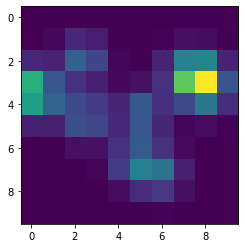

In [8]:
plt.imshow(heatmapsFromMemData[MemData.stimuli[0]]['S02'])

In [9]:
anglesRDMs = RSA_from_angles(anglesFromMemData, kind='simple')
heatmapsRDMs = RSA_from_heatmaps(heatmapsFromMemData)
heatmaps20RDMs = RSA_from_heatmaps(heatmapsFromMemData20)
heatmaps50RDMs = RSA_from_heatmaps(heatmapsFromMemData50)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [52]:
eucDistRDMs = RSA_from_euc_dists(eucDistsfromMemData)
eucDistRDMsClosest = RSA_from_euc_dists(eucDistsfromMemData, kind='single')

In [11]:
heatmapsRDMswithPen = RSA_from_heatmaps(heatmapsFromMemData, heatmapPenalty)

In [12]:
anglesRDMseuc = RSA_from_angles(anglesFromMemData, kind='euclidean')

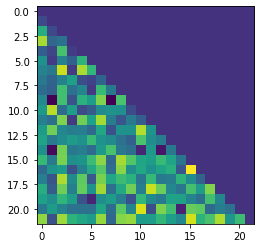

In [13]:
plt.imshow(heatmapsRDMs[MemData.stimuli[3]]);

memory data as RDM, green = at least one subj forgot, yellow = both subj remembered, 0 = erased, only lower triangle is of relevance

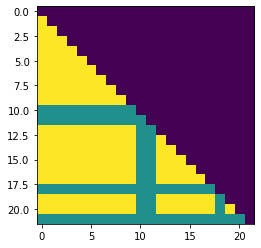

In [14]:
plt.imshow(memRDMs[MemData.stimuli[3]]);

In [15]:
def plotRDMdifferences(rdms, memrdms, vis=False):
    mem1a = []
    mem2b = []
    for img in rdms:
        mem1h = rdms[img][memrdms[img] == 2]
        mem2h = rdms[img][memrdms[img] == 1]
        mem1a.append(np.mean(mem1h))
        mem2b.append(np.mean(mem2h))
    if vis:
        plt.figure(figsize=(10, 10))
        plt.plot(mem1a)
        plt.plot(mem2b)
    return mem1a, mem2b

show that outside of frame fixations are more common in memory bin 2

In [16]:
#
result = MemData.data.groupby('Stimulus').apply(
    lambda x: x.set_index('subjectID')['memory_bin'].to_dict()
).to_dict()
combined_data = {}
for stimulus in result.keys():
    for subject, memory_bin in result[stimulus].items():
        if stimulus not in combined_data:
            combined_data[stimulus] = {}
        combined_data[stimulus][subject] = {
            'memory_bin': memory_bin,
            'penalty': heatmapPenalty[stimulus][subject]
        }
rows = []
for stimulus, subjects in combined_data.items():
    for subject, values in subjects.items():
        rows.append({
            'Stimulus': stimulus,
            'subjectID': subject,
            'memory_bin': values['memory_bin'],
            'penalty': values['penalty']
        })

# Create DataFrame from rows
final_df = pd.DataFrame(rows)

# Calculate average penalty for each memory_bin group
average_penalty_by_memory_bin = final_df.groupby('memory_bin')['penalty'].mean()

print(average_penalty_by_memory_bin)

memory_bin
1.0    0.183406
2.0    0.504814
Name: penalty, dtype: float64


In [17]:
final_df.head()

,Stimulus,subjectID,memory_bin,penalty
0,set1_s_1.png,S06,2.0,0
1,set1_s_1.png,S20,1.0,0
2,set1_s_1.png,S42,1.0,0
3,set1_s_1.png,S34,1.0,0
4,set1_s_1.png,S12,1.0,0


In [18]:
hmmem20_1, hmmem20_2 = plotRDMdifferences(heatmaps20RDMs, memRDMs)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


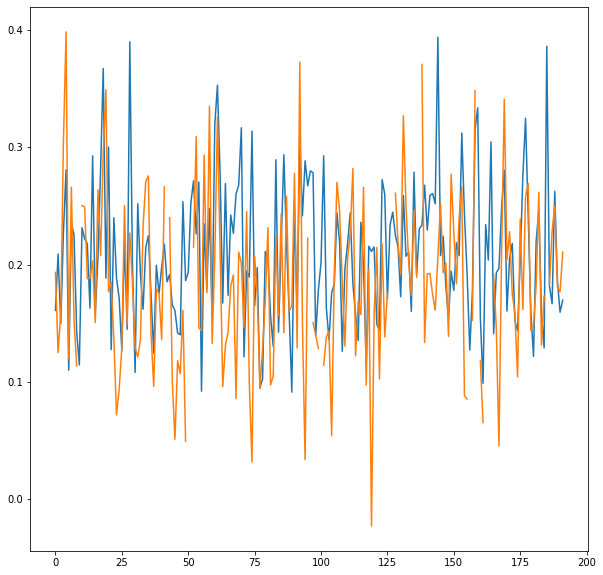

In [19]:
hmmem50_1, hmmem50_2 = plotRDMdifferences(heatmaps50RDMs, memRDMs, vis=True)

In [20]:
hmmem_1, hmmem_2 = plotRDMdifferences(heatmapsRDMs, memRDMs)

In [21]:
anglesFromMemData['set1_s_56.png'].keys()

dict_keys(['S42', 'S06', 'S20', 'S34', 'S28', 'S12', 'S18', 'S40', 'S04', 'S22', 'S10', 'S36', 'S38', 'S02', 'S46', 'S30', 'S16', 'S26', 'S14', 'S50', 'S32', 'S44'])

In [22]:
heatmapsFromMemData['set1_s_56.png'].keys()

dict_keys(['S42', 'S06', 'S20', 'S34', 'S28', 'S12', 'S18', 'S40', 'S04', 'S22', 'S10', 'S36', 'S38', 'S02', 'S46', 'S30', 'S16', 'S44', 'S26', 'S14', 'S50', 'S32'])

noticed this oddity that some participants only have fixations outside of the frame. 

In [23]:
MemData.data[(MemData.data.Stimulus == 'set1_s_56.png') & (MemData.data.subjectID == 'S44')]

,subjectID,trial,duration,Stimulus,cat,memory,trial_on,trial_off,subID_num,viewing_position,mean_x,mean_y,memory_bin
91,S44,16,26.0,set1_s_56.png,2,4.0,126.219266,129.235704,44,0,274.9,818.4,2.0
92,S44,16,26.0,set1_s_56.png,2,4.0,126.219266,129.235704,44,0,273.2,709.6,2.0
93,S44,16,37.0,set1_s_56.png,2,4.0,126.219266,129.235704,44,0,270.8,624.7,2.0
94,S44,16,353.0,set1_s_56.png,2,4.0,126.219266,129.235704,44,0,246.2,583.1,2.0
95,S44,16,192.0,set1_s_56.png,2,4.0,126.219266,129.235704,44,0,290.1,1289.9,2.0


In [24]:
angle_mem1 , angle_mem2 = plotRDMdifferences(anglesRDMs, memRDMs)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [25]:
angleeuc_mem1 , angleuc_mem2 = plotRDMdifferences(anglesRDMseuc, memRDMs)

In [26]:
hmmem_1_pen, hmmem_2_pen = plotRDMdifferences(heatmapsRDMswithPen, memRDMs)

In [53]:
euc_mem1, euc_mem2 = plotRDMdifferences(eucDistRDMs, memRDMs)
euc_mem1c, euc_mem2c = plotRDMdifferences(eucDistRDMsClosest, memRDMs)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [55]:
df_hm = pd.DataFrame({'hm' :['hm1', 'hm1', 'hm2', 'hm2', 'hm5', 'hm5', 'hmpen', 'hmpen', 'angle_avg_dist', 'angle_avg_dist', 'angle_single_dist', 'angle_single_dist', 'euc', 'euc', 'eucC','eucC'],
                      'memory': ['mem1', 'mem2', 'mem1', 'mem2', 'mem1', 'mem2', 'mem1', 'mem2', 'mem1','mem2', 'mem1','mem2', 'mem1','mem2', 'mem1','mem2'],
                      'values':[ np.nanmean(hmmem_1),np.nanmean(hmmem_2), np.nanmean(hmmem20_1), np.nanmean(hmmem20_2), np.nanmean(hmmem50_1), np.nanmean(hmmem50_2),np.nanmean(hmmem_1_pen),np.nanmean(hmmem_2_pen), np.nanmean(angle_mem1), np.nanmean(angle_mem2), np.nanmean(angleeuc_mem1), np.nanmean(angleuc_mem2), np.nanmean(euc_mem1)/1000, np.nanmean(euc_mem2)/1000, np.nanmean(euc_mem1c)/1000, np.nanmean(euc_mem2c)/1000]})

In [56]:
df_hm.values

array([['hm1', 'mem1', 0.29032385897703494],
       ['hm1', 'mem2', 0.2566698236174554],
       ['hm2', 'mem1', 0.23077369824923757],
       ['hm2', 'mem2', 0.20330952860092383],
       ['hm5', 'mem1', 0.20949987037553094],
       ['hm5', 'mem2', 0.18442665749246703],
       ['hmpen', 'mem1', 0.27740356722243875],
       ['hmpen', 'mem2', 0.23753563916434717],
       ['angle_avg_dist', 'mem1', 0.5541433667592326],
       ['angle_avg_dist', 'mem2', 0.5582332584800461],
       ['angle_single_dist', 'mem1', 0.21246626324509088],
       ['angle_single_dist', 'mem2', 0.2122201190681666],
       ['euc', 'mem1', 0.18320754427737312],
       ['euc', 'mem2', 0.20223234214280875],
       ['eucC', 'mem1', 0.08059558530099263],
       ['eucC', 'mem2', 0.09993974407906489]], dtype=object)

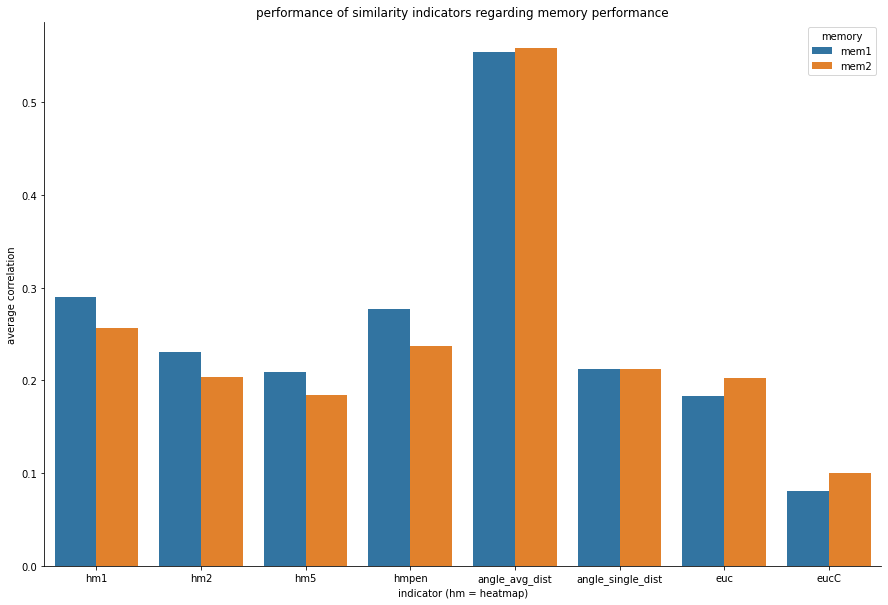

In [57]:
plt.figure(figsize=(15,10))
sns.barplot(x='hm', y='values', hue='memory', data=df_hm)
sns.despine()
plt.title('performance of similarity indicators regarding memory performance')
plt.ylabel('average correlation')
plt.xlabel('indicator (hm = heatmap)');


In [31]:
result = []

In [32]:
eucKeyList = list(eucDistsfromMemData.keys())

In [33]:
eucKeyList[0]

'set1_s_1.png'

In [34]:
testStimkeys = eucDistsfromMemData[eucKeyList[0]]

In [35]:
testKeyList = list(testStimkeys.keys())

In [36]:
eucSub1 = testStimkeys[testKeyList[0]]
eucSub2 = testStimkeys[testKeyList[1]]


In [42]:
eucSub2

array([[245.3, 303.2],
       [373.9, 325. ],
       [385.8, 189.8],
       [115.5, 190.9],
       [340.1, 284.6],
       [454.1, 313.3],
       [405.9, 192.5],
       [447.7, 210.5],
       [339.5, 391.1],
       [163.2, 295.4]])

In [37]:
distances = cdist(eucSub1, eucSub2, metric='euclidean')

# Compute the average distance
average_distance = np.mean(distances)

In [38]:
distances

array([[150.76501584,  84.73753596,  51.00686228, 271.6045655 ,
         61.03253231, 101.96724964,  53.57984696,  71.85457536,
        156.42621264, 226.0189815 ],
       [ 89.46647417, 218.91288222, 238.65640574,  92.93922746,
        178.97276329, 295.45750964, 256.78648718, 292.5515681 ,
        214.30972913,  23.85372088],
       [132.1871779 ,   3.48281495, 132.85458216, 291.8532508 ,
         52.12763183,  78.51751397, 133.17687487, 132.76219341,
         77.92945528, 214.59268394],
       [191.54388531, 116.26770833,  40.59273334, 301.8047879 ,
        101.98833267, 103.76882962,  26.30076045,  32.10436107,
        190.52099622, 264.95790232],
       [236.32393023, 186.32155002,  56.98359413, 308.49423009,
        161.44398409, 172.01351691,  50.07564278,  71.2927065 ,
        259.46724263, 298.23468946],
       [194.39138355, 169.41301603,  36.9545667 , 258.71950062,
        132.83783347, 177.88361364,  50.24360656,  93.6740092 ,
        237.70473281, 251.11352015],
       [18

In [39]:
average_distance

189.05151479222909

In [ ]:

closest_indices = np.argmin(distances, axis=1)

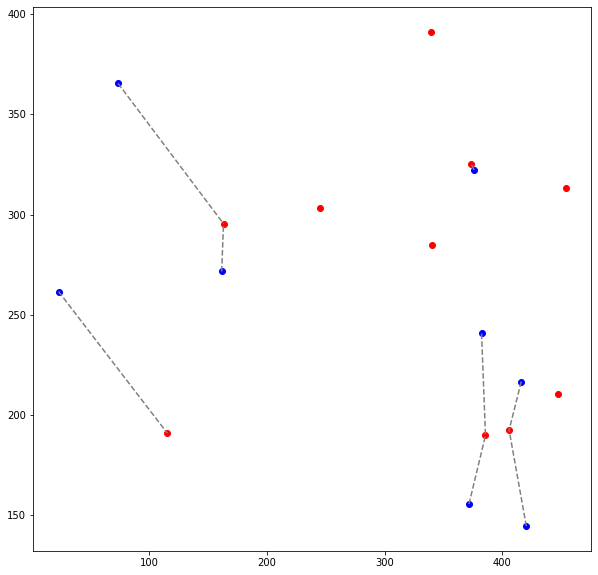

In [49]:
plt.figure(figsize=(10, 10))
plt.scatter(eucSub1[:, 0], eucSub1[:, 1], c='blue', label='S18')

# Plot S40 coordinates
plt.scatter(eucSub2[:, 0], eucSub2[:, 1], c='red', label='S40')

for i in range(len(eucSub1)):
    # Start point from eucSub1
    start_point = eucSub1[i]
    
    # End point from eucSub2 using the closest index
    end_point = eucSub2[closest_indices[i]]
    
    # Draw the connecting line
    plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'grey', linestyle='--')

In [50]:

closest_distances = distances[np.arange(distances.shape[0]), closest_indices]

In [51]:
closest_distances

array([ 51.00686228,  23.85372088,   3.48281495,  26.30076045,
        50.07564278,  36.9545667 , 113.70206682, 116.42482553])

In [44]:
closest_indices

array([2, 9, 1, 6, 6, 2, 9, 3])

In [59]:

from scipy.stats import entropy

In [60]:

num_bins = 10

# Compute bins along each axis
x_bins = np.linspace(eucSub2[:,0].min(), eucSub2[:,0].max(), num_bins + 1)
y_bins = np.linspace(eucSub2[:,1].min(), eucSub2[:,1].max(), num_bins + 1)

# Digitize (or bin) the coordinate data
x_digitized = np.digitize(eucSub2[:,0], bins=x_bins)
y_digitized = np.digitize(eucSub2[:,1], bins=y_bins)

# Combine digitized x and y to create unique bin pairs for each fixation
bin_pairs = np.array(list(zip(x_digitized, y_digitized)))

In [61]:

# Convert bin pairs to tuple for counting unique pairs
bin_pairs_tuples = [tuple(pair) for pair in bin_pairs]

# Count each unique bin pair
unique, counts = np.unique(bin_pairs_tuples, return_counts=True)

# Calculate probabilities
probabilities = counts / counts.sum()

In [62]:

shannon_entropy = entropy(probabilities, base=2)
print(f'Shannon Entropy: {shannon_entropy} bits')

Shannon Entropy: 3.121928094887362 bits


In [65]:

random_array = np.random.randint(0, 501, size=(100, 2))

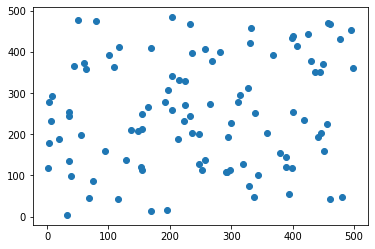

In [67]:
plt.scatter(random_array[:,0], random_array[:,1])

In [69]:
entropy_fix(random_array)

3.336691852698524

In [78]:
entropy_array = []
for img in MemData.data.Stimulus.unique():
    entropy_array.append(entropy_fix(MemData.data[MemData.data.Stimulus == img][['mean_x', 'mean_y']].to_numpy()))

In [75]:
debdata = eucDistsfromMemData['set1_s_49.png']['S38']
debdata

array([[175.8,  62.5],
       [166. ,  -7.4],
       [197.8,   2.8],
       [188.6,  69.5],
       [383.1,  20.4],
       [168.1,  31. ],
       [245.8,  39. ],
       [186.5,  16.3],
       [445.1, 364.3],
       [201.5,  17.6]])

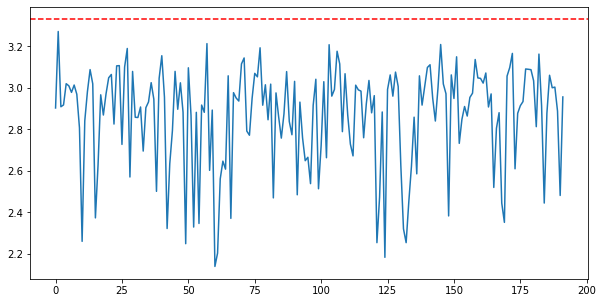

In [79]:
plt.figure(figsize=(10, 5))
plt.plot(entropy_array)
plt.axhline(3.33, color='r', linestyle='--')

ENTROPY MEASURES